In [5]:
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler
import wandb
from IPython.display import Markdown
import datetime

### Dataset Preprocessing

In [6]:
PATH="../merged_annuale_meteo.csv"

In [7]:
DAY_IN_MINUTES = 287

FEATURES = ['timestamp', 
    'INV01_CurrentDC(A)', 'INV01_CurrentAC(A)', 'INV01_TotalEnergy(kWh)','INV01_PowerAC(kW)', 'INV01_PowerDC(kW)',
       'INV01_InternalTemperature(C)', 'INV01_HeatSinkTemperature(C)',
       'INV01_VoltageDC(V)', 'INV01_VoltageAC(V)', 'INV02_CurrentDC(A)',
       'INV02_CurrentAC(A)', 'INV02_TotalEnergy(kWh)', 'INV02_PowerAC(kW)',
       'INV02_PowerDC(kW)', 'INV02_InternalTemperature(C)',
       'INV02_HeatSinkTemperature(C)', 'INV02_VoltageDC(V)',
       'INV02_VoltageAC(V)', 'INV03_CurrentDC(A)', 'INV03_CurrentAC(A)',
       'INV03_TotalEnergy(kWh)', 'INV03_PowerAC(kW)', 'INV03_PowerDC(kW)',
       'INV03_InternalTemperature(C)', 'INV03_HeatSinkTemperature(C)',
       'INV03_VoltageDC(V)', 'INV03_VoltageAC(V)', 'Cont_TotalEnergy(kWh)', 'Cont_TotalEnergyImported(kWh)',
       'Impianto_SolargisGHI(W/m2)', 'Impianto_SolargisGTI(W/m2)',
       'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)', 'rain (mm)', 'cloudcover (%)',
       'soil_temperature_7_to_28cm (°C)', 'soil_moisture_7_to_28cm (m³/m³)'
]

PATH = "merged_annuale_meteo.csv"

In [8]:
#EXCLUDE_FEATURES = [
#    "Failure", "Frequency", "Status", "Others",
#    "Code", "name", "deviceid", "serial",
#    "SB0", "Phase", "NV10P", "TotalEnergy_QuotControl", "TotalEnergyImported"
    #"INV01_TotalEnergy", "INV02_TotalEnergy", "INV03_TotalEnergy",
    #"cos",
    #"sin",
#    "state", "SOL", "NA16", 
    #'soil_moisture_7_to_28cm (m³/m³)',
#]

In [9]:
df = pd.read_csv(PATH, delimiter = ";")
df['timestamp'] = pd.to_datetime(df['timestamp'], yearfirst=True)
df = df[FEATURES]
#cols_to_remove = [column  for column in df.columns if len([elem for elem in EXCLUDE_FEATURES if elem in column]) > 0]
#df = df.drop(columns=cols_to_remove)

# aggiunta encoding ciclico minuti, giorni
tmp_datetime_serie = pd.to_datetime(arg=df['timestamp'], yearfirst=True)

df["minute_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)
df["minute_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)

df["day_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)
df["day_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)

# trasformo la target series in Non Cumulativa
df['target'] = df['Cont_TotalEnergy(kWh)'].diff().fillna(0)

In [10]:
df = df.set_index(df['timestamp'])

In [11]:
df

,timestamp,INV01_CurrentDC(A),INV01_CurrentAC(A),INV01_TotalEnergy(kWh),INV01_PowerAC(kW),INV01_PowerDC(kW),INV01_InternalTemperature(C),INV01_HeatSinkTemperature(C),INV01_VoltageDC(V),INV01_VoltageAC(V),...,dewpoint_2m (°C),rain (mm),cloudcover (%),soil_temperature_7_to_28cm (°C),soil_moisture_7_to_28cm (m³/m³),minute_sin,minute_cos,day_sin,day_cos,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-02-02 00:05:00,2022-02-02 00:05:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.3,0.0,13.0,9.1,0.319,0.500000,8.660254e-01,0.394356,0.918958,0.0
2022-02-02 00:10:00,2022-02-02 00:10:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.6,0.0,13.0,9.1,0.319,0.866025,5.000000e-01,0.394356,0.918958,0.0
2022-02-02 00:15:00,2022-02-02 00:15:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.6,0.0,13.0,9.1,0.319,1.000000,2.832769e-16,0.394356,0.918958,0.0
2022-02-02 00:20:00,2022-02-02 00:20:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.6,0.0,13.0,9.1,0.319,0.866025,-5.000000e-01,0.394356,0.918958,0.0
2022-02-02 00:25:00,2022-02-02 00:25:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.6,0.0,13.0,9.1,0.319,0.500000,-8.660254e-01,0.394356,0.918958,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16 17:45:00,2023-06-16 17:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.2,0.0,50.0,21.0,0.371,-1.000000,-1.836970e-16,-0.101168,-0.994869,13.5
2023-06-16 17:50:00,2023-06-16 17:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.2,0.0,50.0,21.0,0.371,-0.866025,5.000000e-01,-0.101168,-0.994869,13.5
2023-06-16 17:55:00,2023-06-16 17:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.2,0.0,50.0,21.0,0.371,-0.500000,8.660254e-01,-0.101168,-0.994869,13.5


### Media Giornaliera Total Energy (e prove diff/cumsum)

In [30]:
# TODO: ricontrollare !
#       va aggiunto il valore iniziale di target. Si parte da quello a fare cumsum
ttest = pd.DataFrame()
ttest['diff'] = df['Cont_TotalEnergy(kWh)'].diff().fillna(method='bfill')
ttest['opposite'] = ttest['diff'].cumsum()
ttest['target'] = df['Cont_TotalEnergy(kWh)']
ttest

,diff,opposite,target
timestamp,,,
2022-02-02 00:05:00,0.0,0.0,8671077.0
2022-02-02 00:10:00,0.0,0.0,8671077.0
2022-02-02 00:15:00,0.0,0.0,8671077.0
2022-02-02 00:20:00,0.0,0.0,8671077.0
2022-02-02 00:25:00,0.0,0.0,8671077.0
...,...,...,...
2023-06-16 17:45:00,13.5,1484500.5,10155577.5
2023-06-16 17:50:00,13.5,1484514.0,10155591.0
2023-06-16 17:55:00,13.5,1484527.5,10155604.5


10153390.5


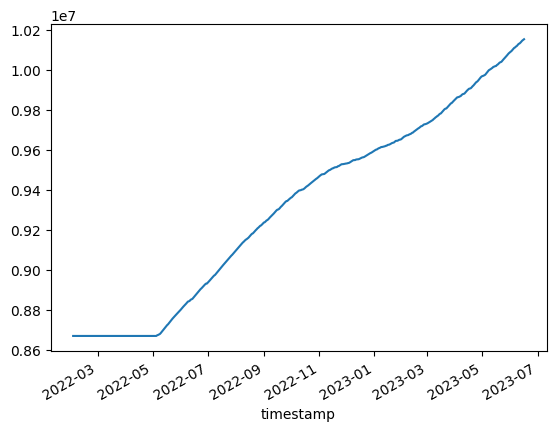

In [11]:
df.asfreq('1d')['Cont_TotalEnergy(kWh)'].plot()
print(df.asfreq('1d')['Cont_TotalEnergy(kWh)'][-1])

1484541.0


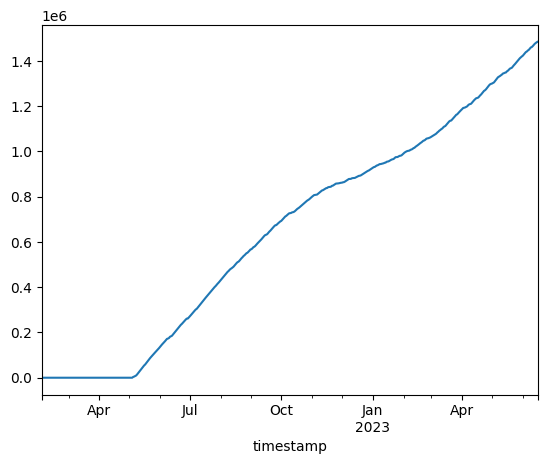

In [10]:
df.resample('1d').sum()['target'].cumsum().plot()
print(df.resample('1d').sum()['target'].cumsum()[-1])

In [ ]:
media_prod_giornaliera= df.resample('1d').sum()['target'].mean()

2969.082

### Resampling a 15 Min

In [8]:
# resample in H
df = df.resample('15Min').sum() # No sum su TotalEnergy

In [9]:
df

,INV01_CurrentDC(A),INV01_CurrentAC(A),INV01_TotalEnergy(kWh),INV01_PowerAC(kW),INV01_PowerDC(kW),INV01_InternalTemperature(C),INV01_HeatSinkTemperature(C),INV01_VoltageDC(V),INV01_VoltageAC(V),INV02_CurrentDC(A),...,dewpoint_2m (°C),rain (mm),cloudcover (%),soil_temperature_7_to_28cm (°C),soil_moisture_7_to_28cm (m³/m³),minute_sin,minute_cos,day_sin,day_cos,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-02-02 00:00:00,443.76,534.86,9971487.36,241.26,256.70,35.6,97.42,1157.06,522.50,453.96,...,-0.9,0.0,26.0,18.2,0.638,1.366025,1.366025,0.788712,1.837916,0.0
2022-02-02 00:15:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,-1.8,0.0,39.0,27.3,0.957,2.366025,-1.366025,1.183068,2.756873,0.0
2022-02-02 00:30:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,-1.8,0.0,39.0,27.3,0.957,-1.366025,-2.366025,1.183068,2.756873,0.0
2022-02-02 00:45:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,-1.8,0.0,39.0,27.3,0.957,-2.366025,1.366025,1.183068,2.756873,0.0
2022-02-02 01:00:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,-2.4,0.0,35.0,27.1,0.957,1.366025,2.366025,1.183068,2.756873,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16 17:00:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,332.06,...,42.5,0.0,145.0,62.9,1.114,1.366025,2.366025,-0.303505,-2.984608,40.5
2023-06-16 17:15:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,320.10,...,42.6,0.0,150.0,63.0,1.113,2.366025,-1.366025,-0.303505,-2.984608,40.5
2023-06-16 17:30:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,346.12,...,42.6,0.0,150.0,63.0,1.113,-1.366025,-2.366025,-0.303505,-2.984608,54.0


### Is Day

In [13]:
isday = pd.read_csv('isday.csv', header=2, sep=',', index_col=False, parse_dates=['time'])

In [14]:
isday.index = isday['time']

In [15]:
isday.drop(columns=['time'], inplace=True)

In [16]:
isday = isday.resample('15Min').ffill()

In [17]:
isday = isday[:len(df)]

In [18]:
isday

,is_day ()
time,
2022-02-02 00:00:00,0
2022-02-02 00:15:00,0
2022-02-02 00:30:00,0
2022-02-02 00:45:00,0
2022-02-02 01:00:00,0
...,...
2023-06-16 17:00:00,1
2023-06-16 17:15:00,1
2023-06-16 17:30:00,1


In [19]:
# df = pd.concat([df, isday], axis=1)

### Custom Is Day

In [20]:
sunsetrise = pd.read_csv("sunriseset.csv", header=2, sep=',', index_col=False, parse_dates=[
    'time', 'sunrise (iso8601)', 'sunset (iso8601)'])
sunsetrise.index = sunsetrise['time']
sunsetrise.drop(columns=['time'], inplace=True)
sunsetrise.columns = ['sunrise', 'sunset']
sunsetrise = sunsetrise.loc[:df.index[-1]]

In [21]:
sunsetrise

,sunrise,sunset
time,,
2022-02-02,2022-02-02 08:01:00,2022-02-02 18:09:00
2022-02-03,2022-02-03 08:00:00,2022-02-03 18:10:00
2022-02-04,2022-02-04 07:59:00,2022-02-04 18:12:00
2022-02-05,2022-02-05 07:58:00,2022-02-05 18:13:00
2022-02-06,2022-02-06 07:57:00,2022-02-06 18:14:00
...,...,...
2023-06-12,2023-06-12 05:19:00,2023-06-12 20:24:00
2023-06-13,2023-06-13 05:18:00,2023-06-13 20:25:00
2023-06-14,2023-06-14 05:18:00,2023-06-14 20:25:00


In [33]:
df

,INV01_CurrentDC(A),INV01_CurrentAC(A),INV01_TotalEnergy(kWh),INV01_PowerAC(kW),INV01_PowerDC(kW),INV01_InternalTemperature(C),INV01_HeatSinkTemperature(C),INV01_VoltageDC(V),INV01_VoltageAC(V),INV02_CurrentDC(A),...,dewpoint_2m (°C),rain (mm),cloudcover (%),soil_temperature_7_to_28cm (°C),soil_moisture_7_to_28cm (m³/m³),minute_sin,minute_cos,day_sin,day_cos,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-02-02 00:00:00,443.76,534.86,9971487.36,241.26,256.70,35.6,97.42,1157.06,522.50,453.96,...,-0.9,0.0,26.0,18.2,0.638,1.366025,1.366025,0.788712,1.837916,0.0
2022-02-02 00:15:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,-1.8,0.0,39.0,27.3,0.957,2.366025,-1.366025,1.183068,2.756873,0.0
2022-02-02 00:30:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,-1.8,0.0,39.0,27.3,0.957,-1.366025,-2.366025,1.183068,2.756873,0.0
2022-02-02 00:45:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,-1.8,0.0,39.0,27.3,0.957,-2.366025,1.366025,1.183068,2.756873,0.0
2022-02-02 01:00:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,-2.4,0.0,35.0,27.1,0.957,1.366025,2.366025,1.183068,2.756873,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16 17:00:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,332.06,...,42.5,0.0,145.0,62.9,1.114,1.366025,2.366025,-0.303505,-2.984608,40.5
2023-06-16 17:15:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,320.10,...,42.6,0.0,150.0,63.0,1.113,2.366025,-1.366025,-0.303505,-2.984608,40.5
2023-06-16 17:30:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,346.12,...,42.6,0.0,150.0,63.0,1.113,-1.366025,-2.366025,-0.303505,-2.984608,54.0


In [22]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [52]:
def custom_isday(sunrise, sunset):
    tmp_df = pd.DataFrame(
        0,
        index=df[
            ((df.index >= pd.to_datetime(sunrise.date())) * 
             (df.index < pd.to_datetime(sunrise.date() + datetime.timedelta(days=1))))
        ].index,
        columns=['isday']
    )

    # print(tmp_df.shape)
    
    start = nearest(tmp_df.index, sunrise)
    end = nearest(tmp_df.index,sunset)
    
    # print(start, "-", end)

    tmp_df[((tmp_df.index >= start) * (tmp_df.index <= end))] = 1
    
    return tmp_df

In [53]:
# sunsetrise[sunsetrise.index >= pd.to_datetime('2022-12-01')]

In [55]:
customisday = pd.DataFrame()

for index, (sunrise, sunset) in sunsetrise.iterrows():
    test = custom_isday(sunrise, sunset)
    customisday = pd.concat([customisday, test])

(96, 1)
2022-02-02 08:00:00 - 2022-02-02 18:15:00
(96, 1)
2022-02-03 08:00:00 - 2022-02-03 18:15:00
(96, 1)
2022-02-04 08:00:00 - 2022-02-04 18:15:00
(96, 1)
2022-02-05 08:00:00 - 2022-02-05 18:15:00
(96, 1)
2022-02-06 08:00:00 - 2022-02-06 18:15:00
(96, 1)
2022-02-07 08:00:00 - 2022-02-07 18:15:00
(96, 1)
2022-02-08 08:00:00 - 2022-02-08 18:15:00
(96, 1)
2022-02-09 08:00:00 - 2022-02-09 18:15:00
(96, 1)
2022-02-10 07:45:00 - 2022-02-10 18:15:00
(96, 1)
2022-02-11 07:45:00 - 2022-02-11 18:15:00
(96, 1)
2022-02-12 07:45:00 - 2022-02-12 18:15:00
(96, 1)
2022-02-13 07:45:00 - 2022-02-13 18:30:00
(96, 1)
2022-02-14 07:45:00 - 2022-02-14 18:30:00
(96, 1)
2022-02-15 07:45:00 - 2022-02-15 18:30:00
(96, 1)
2022-02-16 07:45:00 - 2022-02-16 18:30:00
(96, 1)
2022-02-17 07:45:00 - 2022-02-17 18:30:00
(96, 1)
2022-02-18 07:45:00 - 2022-02-18 18:30:00
(96, 1)
2022-02-19 07:45:00 - 2022-02-19 18:30:00
(96, 1)
2022-02-20 07:45:00 - 2022-02-20 18:30:00
(96, 1)
2022-02-21 07:45:00 - 2022-02-21 18:30:00


In [56]:
customisday

,isday
timestamp,
2022-02-02 00:00:00,0
2022-02-02 00:15:00,0
2022-02-02 00:30:00,0
2022-02-02 00:45:00,0
2022-02-02 01:00:00,0
...,...
2023-06-16 17:00:00,1
2023-06-16 17:15:00,1
2023-06-16 17:30:00,1


In [34]:
df = pd.concat([df, customisday], axis=1)

,INV01_CurrentDC(A),INV01_CurrentAC(A),INV01_TotalEnergy(kWh),INV01_PowerAC(kW),INV01_PowerDC(kW),INV01_InternalTemperature(C),INV01_HeatSinkTemperature(C),INV01_VoltageDC(V),INV01_VoltageAC(V),INV02_CurrentDC(A),...,cloudcover (%),soil_temperature_7_to_28cm (°C),soil_moisture_7_to_28cm (m³/m³),minute_sin,minute_cos,day_sin,day_cos,target,is_day (),isday
2022-02-02 00:00:00,443.76,534.86,9971487.36,241.26,256.70,35.6,97.42,1157.06,522.50,453.96,...,26.0,18.2,0.638,1.366025,1.366025,0.788712,1.837916,0.0,0,0
2022-02-02 00:15:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,39.0,27.3,0.957,2.366025,-1.366025,1.183068,2.756873,0.0,0,0
2022-02-02 00:30:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,39.0,27.3,0.957,-1.366025,-2.366025,1.183068,2.756873,0.0,0,0
2022-02-02 00:45:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,39.0,27.3,0.957,-2.366025,1.366025,1.183068,2.756873,0.0,0,0
2022-02-02 01:00:00,665.64,802.29,14957231.04,361.89,385.05,53.4,146.13,1735.59,783.75,680.94,...,35.0,27.1,0.957,1.366025,2.366025,1.183068,2.756873,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16 17:00:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,332.06,...,145.0,62.9,1.114,1.366025,2.366025,-0.303505,-2.984608,40.5,1,1
2023-06-16 17:15:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,320.10,...,150.0,63.0,1.113,2.366025,-1.366025,-0.303505,-2.984608,40.5,1,1
2023-06-16 17:30:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,346.12,...,150.0,63.0,1.113,-1.366025,-2.366025,-0.303505,-2.984608,54.0,1,1
2023-06-16 17:45:00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,321.28,...,150.0,63.0,1.113,-2.366025,1.366025,-0.303505,-2.984608,40.5,1,1


### Rimozioni giorni con dati mancanti

In [12]:
DATES_TO_REMOVE = [
    '2022-06-09', '2022-06-10', '2022-06-11', '2022-06-12', '2022-06-13',
       '2022-06-28', '2022-06-29', '2022-06-30', '2022-08-26', '2022-09-23',
       '2022-10-06', '2023-02-03', '2023-02-15', '2023-02-16', '2023-03-26',
]

In [14]:
def remove_day(day):
    to_drop = df[(((df.index >= pd.to_datetime(day)) * (df.index < (pd.to_datetime(day) + datetime.timedelta(days=1)))))].index
    
    # print(to_drop)
    
    df.drop(to_drop, inplace=True)

In [15]:
for day in DATES_TO_REMOVE:
    # print(day)
    remove_day(day)

DatetimeIndex(['2022-06-09 00:05:00', '2022-06-09 00:10:00',
               '2022-06-09 00:15:00', '2022-06-09 00:20:00',
               '2022-06-09 00:25:00', '2022-06-09 00:30:00',
               '2022-06-09 00:35:00', '2022-06-09 00:40:00',
               '2022-06-09 00:45:00', '2022-06-09 00:50:00',
               ...
               '2022-06-09 23:10:00', '2022-06-09 23:15:00',
               '2022-06-09 23:20:00', '2022-06-09 23:25:00',
               '2022-06-09 23:30:00', '2022-06-09 23:35:00',
               '2022-06-09 23:40:00', '2022-06-09 23:45:00',
               '2022-06-09 23:50:00', '2022-06-09 23:55:00'],
              dtype='datetime64[ns]', name='timestamp', length=287, freq=None)
DatetimeIndex(['2022-06-10 00:05:00', '2022-06-10 00:10:00',
               '2022-06-10 00:15:00', '2022-06-10 00:20:00',
               '2022-06-10 00:25:00', '2022-06-10 00:30:00',
               '2022-06-10 00:35:00', '2022-06-10 00:40:00',
               '2022-06-10 00:45:00', '2022-06-

In [ ]:
df

,timestamp,INV01_CurrentDC(A),INV01_CurrentAC(A),INV01_TotalEnergy(kWh),INV01_PowerAC(kW),INV01_PowerDC(kW),INV01_InternalTemperature(C),INV01_HeatSinkTemperature(C),INV01_VoltageDC(V),INV01_VoltageAC(V),...,dewpoint_2m (°C),rain (mm),cloudcover (%),soil_temperature_7_to_28cm (°C),soil_moisture_7_to_28cm (m³/m³),minute_sin,minute_cos,day_sin,day_cos,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-02-02 00:05:00,2022-02-02 00:05:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.3,0.0,13.0,9.1,0.319,0.500000,8.660254e-01,0.394356,0.918958,0.0
2022-02-02 00:10:00,2022-02-02 00:10:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.6,0.0,13.0,9.1,0.319,0.866025,5.000000e-01,0.394356,0.918958,0.0
2022-02-02 00:15:00,2022-02-02 00:15:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.6,0.0,13.0,9.1,0.319,1.000000,2.832769e-16,0.394356,0.918958,0.0
2022-02-02 00:20:00,2022-02-02 00:20:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.6,0.0,13.0,9.1,0.319,0.866025,-5.000000e-01,0.394356,0.918958,0.0
2022-02-02 00:25:00,2022-02-02 00:25:00,221.88,267.43,4985743.68,120.63,128.35,17.8,48.71,578.53,261.25,...,-0.6,0.0,13.0,9.1,0.319,0.500000,-8.660254e-01,0.394356,0.918958,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16 17:45:00,2023-06-16 17:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.2,0.0,50.0,21.0,0.371,-1.000000,-1.836970e-16,-0.101168,-0.994869,13.5
2023-06-16 17:50:00,2023-06-16 17:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.2,0.0,50.0,21.0,0.371,-0.866025,5.000000e-01,-0.101168,-0.994869,13.5
2023-06-16 17:55:00,2023-06-16 17:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.2,0.0,50.0,21.0,0.371,-0.500000,8.660254e-01,-0.101168,-0.994869,13.5


### Train, Val, Test Split

In [ ]:
train_df = df[((df.index >= '2022-06-01') * (df.index < '2023-01-01'))]
val_df = df[((df.index >= '2023-01-01') * (df.index < '2023-02-01'))]
test_df = df[((df.index >= '2023-02-01') * (df.index < '2023-03-01'))]

In [ ]:
train_scaler = MinMaxScaler()
train_scaler.fit(train_df)

train_target_scaler = MinMaxScaler()
train_target_scaler.fit(train_df['target'].to_numpy().reshape(-1, 1))

#tmp_data = train_scaler.transform(train_df)
train_df = pd.DataFrame(train_scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
val_df = pd.DataFrame(train_scaler.transform(val_df), columns=val_df.columns, index=val_df.index)
test_df = pd.DataFrame(train_scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

In [ ]:
display(Markdown("### Training Dataframe"))
display(train_df)

display(Markdown("### Validation Dataframe"))
display(val_df)

display(Markdown("### Testing Dataframe"))
display(test_df)

#### Test 1

In [ ]:
test_df_1 = df[((df.index >= '2023-03-01') * (df.index < '2023-04-01'))]
test_df_2 = df[((df.index >= '2023-04-01') * (df.index < '2023-05-01'))]

In [ ]:
test_df_1 = pd.DataFrame(train_scaler.transform(test_df_1), columns=test_df_1.columns, index=test_df_1.index)
test_df_2 = pd.DataFrame(train_scaler.transform(test_df_2), columns=test_df_2.columns, index=test_df_2.index)

#### Test 2

In [ ]:
train_df_2 = df[((df.index >= '2022-06-01') * (df.index < '2023-03-01'))]
val_df_2 = df[((df.index >= '2023-03-01') * (df.index < '2023-04-01'))]
test_df_2_2 = df[((df.index >= '2023-04-01') * (df.index < '2023-05-01'))]

In [ ]:
train_scaler_2 = MinMaxScaler()
train_scaler_2.fit(train_df_2)

train_target_scaler_2 = MinMaxScaler()
train_target_scaler_2.fit(train_df_2['target'].to_numpy().reshape(-1, 1))

#tmp_data = train_scaler.transform(train_df)
train_df_2 = pd.DataFrame(train_scaler_2.transform(train_df_2), columns=train_df_2.columns, index=train_df_2.index)
val_df_2 = pd.DataFrame(train_scaler_2.transform(val_df_2), columns=val_df_2.columns, index=val_df_2.index)
test_df_2_2 = pd.DataFrame(train_scaler_2.transform(test_df_2_2), columns=test_df_2_2.columns, index=test_df_2_2.index)

In [ ]:
datasets = {
    "original": [train_df, val_df, test_df, train_scaler, train_target_scaler],
    "test 1": [train_df, val_df, test_df_1, test_df_2, train_scaler, train_target_scaler],
    "test 2": [train_df_2, val_df_2, test_df_2_2, train_scaler_2, train_target_scaler_2]
}

### Dataset & DataLoader

In [ ]:
BATCH_SIZE = 10

In [ ]:
class CustomDataset(Dataset):
    MAX_DAYS = 4
    MIN_DAYS = 1
    DAY_IN_TIMESTAMPS = 96 # 15 min

    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        self.counter = 0
        self.target_len = -1
    
    def __len__(self):
        return int(len(self.df)/self.DAY_IN_TIMESTAMPS)-2 - self.MAX_DAYS
    
    def __getitem__(self, idx):
        if self.counter == self.batch_size:
            self.counter = 0
        
        if self.counter == 0:
            self.target_len = np.random.randint(1, self.MAX_DAYS+1)
        
        tmp_df = self.df.iloc[0+(self.DAY_IN_TIMESTAMPS*(idx+1)) - self.DAY_IN_TIMESTAMPS : (self.DAY_IN_TIMESTAMPS*(idx+1))+(self.DAY_IN_TIMESTAMPS*self.target_len) + self.DAY_IN_TIMESTAMPS]
        timestamps = tmp_df.index
        #timestamps = tmp_df['timestamp']
        #tmp_df = tmp_df.drop(columns=['timestamp'])

        mask_before = np.array([1]*self.DAY_IN_TIMESTAMPS + [0]*(len(tmp_df) - self.DAY_IN_TIMESTAMPS))
        mask_after = np.array([0] * (len(tmp_df) - self.DAY_IN_TIMESTAMPS) + [1]*self.DAY_IN_TIMESTAMPS)
        mask_target = np.array([0]*self.DAY_IN_TIMESTAMPS + [1] * (len(tmp_df) - self.DAY_IN_TIMESTAMPS*2) +[0] * self.DAY_IN_TIMESTAMPS)
        
        # print(len(mask_target), f"{timestamps[0]}-{timestamps[-1]}")
        
        before = tmp_df[mask_before == 1]
        target = tmp_df[mask_target == 1]
        after  = tmp_df[mask_after == 1]
        
        future = target.copy()
        future = future[[
            'Impianto_SolargisGHI(W/m2)','Impianto_SolargisGTI(W/m2)', 
            'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_sin', 'day_cos',
            'temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)', 
            'rain (mm)', 'cloudcover (%)', 'soil_temperature_7_to_28cm (°C)', 'soil_moisture_7_to_28cm (m³/m³)',
            'isday',
            #'is_day ()',
        ]]
        
        tsolargis = target[['Impianto_SolargisGHI(W/m2)','Impianto_SolargisGTI(W/m2)']].copy()
        tsolargis.columns = ['GHI', 'GTI']
        
        target = target['target']
        
        self.counter += 1
        
        #print(mask_before)
        #print(mask_target)
        #print(mask_after)
        
        return before, target, future, after, mask_before, mask_target, mask_after, timestamps, tsolargis
    
    def reset(self):
        self.counter = 0

In [ ]:
def collate_fn(batch):
    # ha senso usare del padding ??
    before, target, future, after, masks_before, masks_target, masks_after, timestamps, solargis = zip(*batch)
    
    before = [torch.tensor(d.values, dtype=torch.float32) for d in before]
    before = torch.stack(before)
    
    target = [torch.tensor(d.values, dtype=torch.float32) for d in target]
    target = [torch.reshape(d, (d.shape[0], 1)) for d in target] # voglio shape [len_buco, 1]
    target = torch.stack(target)
    
    future = [torch.tensor(d.values, dtype=torch.float32) for d in future]
    future = torch.stack(future)
    
    after = [torch.tensor(d.values, dtype=torch.float32) for d in after]
    after = torch.stack(after)
    
    return before, target, future, after, masks_before, masks_target, masks_after, timestamps, solargis